# <center> Improved Arrhythmia Classification Using Select  </center>
# <center>Morphological and Heart Rate Variability ECG Features. </center>
## <center> Mark James Dunbar </center>

<center>School of Electronic Engineering and Computer Science </center>
<center>Queen Mary University of London </center>
<center>London, United Kingdom </center>
<center>ec21896@qmul.ac.uk </center>

## <center> MSc Big Data Science - Final Project </center>



---

# <center>MSc Final Project Experimentation and Final Pipeline Notebook</center>







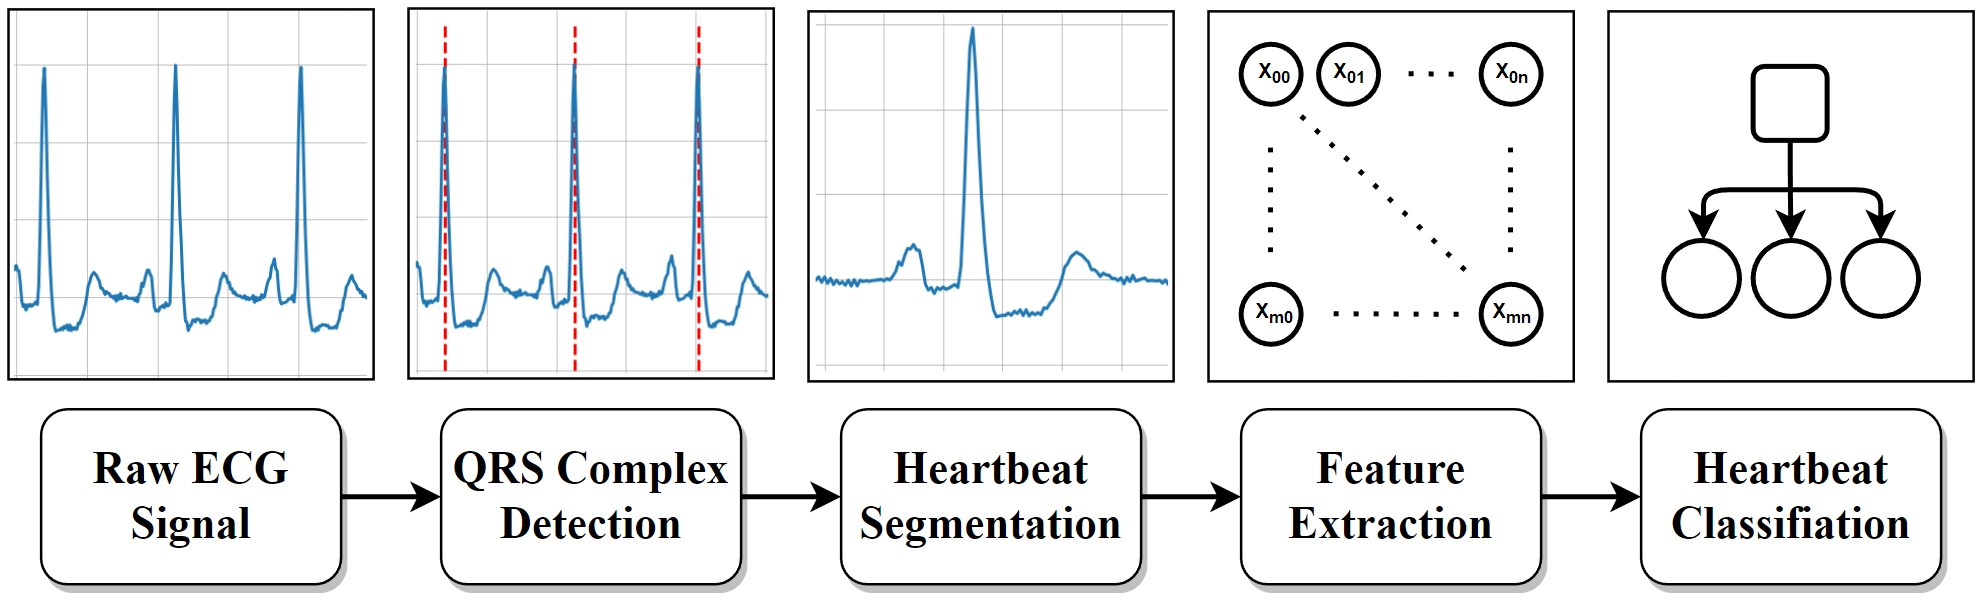

In this notebook, I will Implement the model training, validation and testing on the ECG dataset, producing a ML pipeline that classifies each beat found within the ECG. 

There are two parts to this Notebook

1.   Pipeline Stages Creation
2.   Model training, testing and validation
3.   Final Pipeline Implementation

### Connect to drive for data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### List of Imports

In [ ]:
import datetime
import os
import random
from tqdm import tqdm, notebook

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from scipy.ndimage import label
from scipy.interpolate import interp1d
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.integrate import trapz

!pip install astropy
from astropy.stats import LombScargle

import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


def linebreak():
  print('________________________________________________________________________________')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
# extraction path
extract_to = "drive/MyDrive/data/ECG_extracted_data"
records = os.listdir(extract_to)

# sample rate of ecg signals
srate = 128

### Function to extract ECG records from database

In [ ]:
def get_ecg(records):

  data_matrix = []
  labels_vector = []

  for record in records:
    # acquire the record
    ecg_record = pd.read_pickle(os.path.join(extract_to,record))
    signal = ecg_record['voltage'].tolist()
    labels = ecg_record['label'].tolist()

    # append to data matrix
    data_matrix.append(signal)
    labels_vector.append(labels)

  # return data matrix
  return np.array(data_matrix), labels_vector

### Set initial data matrix X, and feature vector y.

In [ ]:
# create data matrices
X, y = get_ecg(records)

X = pd.DataFrame(X)
y = pd.DataFrame(y)

### R-Peak detection function

In [ ]:
def detect_peaks(ecg_signal, peak_threshold=0.3, grouping_threshold=10):
  '''
  R Peak detection using cross correlation and thresholding template matching
  '''

  # Define our QRS filter - a simple sinewave
  t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
  qrs_filter = np.sin(t)

  # standardise signal
  ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

  # cross correlation
  similarity_score = np.correlate(ecg_signal, qrs_filter, mode="same")

  # standardize
  similarities = similarity_score / np.max(similarity_score)

  # thresholding step
  peak_indexes = ecg_signal[similarities > peak_threshold].index

  # initialize output for peaks
  output = np.empty(0, dtype=int)

  # label groups of indexes that belong to the same R-peak
  peak_groups, num_groups = label(np.diff(peak_indexes) < grouping_threshold)

  # iterate through groups and take the mean as the R-peak index
  for i in np.unique(peak_groups)[1:]:
      peak_group = peak_indexes[np.where(peak_groups == i)]
      output = np.append(output, int(round(np.median(peak_group))))

  return output 

### R-Peak label matching function

In [ ]:
def get_peak_labels(peaks, y):
  labels = []

  for i, item in enumerate(peaks):
    # acquire the label assigned to each peak
    # NO peaks within the dataset occur within +/- 10 samples of each other, 
    # so this method is OK for finding the label associated with a peak
    bag = y[item-10:item+10]

    # if the bag contains only _, there is no label present - delete that entry (for missed peak counting)
    if all(bag) == '_':
      print('No Labels')
      peaks = np.delete(peaks, i)

    # if labels exist, append them. We remove Q and F here as there are not enough Q and F labels for classifier training
    elif all(bag) != '_':
      for item in bag:
        if item != '_' and item != 'Q' and item != 'F':
          labels.append(item)
    
  # if a peak is missed, record it as being missed
  if len(labels) != len(peaks):
    print('{} Peaks Missed'.format(abs(len(peaks)-len(labels))))
    return None, None

  return labels, peaks

### Heartbeat and label extraction function


In [ ]:
def extract_beats(x, peaks, labels):
  
  single_beat_ecgs = []
  single_beat_labels = []

  # for peaks in their indexes, get the single beat signal for the given window
  for i, index in enumerate(peaks):

    # Get the number of samples to collect each side of the beat index
    samp_left, samp_right = int(0.3*srate),int(0.5*srate)

    # Get the indexes left and right of the beat index
    left_index, right_index = (index-samp_left),(index+samp_right)

    # Only capture the beat if the full window can be acquired 
    if left_index > 0 and right_index <= 230399:
      single_beat_ecgs.append(x[left_index:right_index])
      single_beat_labels.append(labels[i])

  return np.array(single_beat_ecgs), np.array(single_beat_labels)

### Extracting the 301 R-peaks before each heartbeat in the dataset. 

Note that beats that do not have 301 preceding R-Peaks are not used in the final dataset. ALL datasets used have to have at least 301 preceding R-Peaks to be used, so that the same set of heartbeats are used in EVERY experiment.



In [ ]:
count = 0

# how many peaks before each heartbeat do we require for HRV calculation?
# 300 RR intervals equate roughly to 5 mins at 60bpm,
# 301 R peaks generate 300 RR intervals
r_peaks_before = 301

beats = []
beat_labels = []
beat_peaks = []

for X_index, x in X.iterrows():
  y_labs = y.iloc[X_index]

  peaks1 = detect_peaks(x, peak_threshold=0.8, grouping_threshold=5)

  peaks2 = peaks1[r_peaks_before:len(peaks1)-1]
    
  labels, peaks = get_peak_labels(peaks2, y_labs)

  if labels == None:
    count += 1

  else: 
    for i, _ in enumerate(peaks):
      prev_x_peaks = peaks1[i:i+r_peaks_before]
      beat_peaks.append(prev_x_peaks)
      #print(prev_x_peaks)

    x_out, y_out = extract_beats(x, peaks, labels)
    beats.append(np.array(x_out))
    beat_labels.append(np.array(y_out))


4 Peaks Missed
6 Peaks Missed


In [ ]:
print("Missed Beat Count: ",10)
print("Missed Beat Percentage: {}%".format((4/36615)*100))

Missed Beat Count:  10
Missed Beat Percentage: 0.010924484500887614%


In [ ]:
print(peaks1[0])
print(X.iloc[0])

5778
0        -0.400044
1         0.085888
2        -0.045597
3         0.042454
4        -0.026027
            ...   
230395   -0.024981
230396   -0.044558
230397   -0.025102
230398   -0.044154
230399   -0.020132
Name: 0, Length: 230400, dtype: float64


In [ ]:
y_labels = np.array(beat_labels)
prev_peaks = np.array(beat_peaks)


print(y_labels[0])
print(prev_peaks[0])

[]
[    60    206    744    892   1155   1296   1427   1546   1938   2340
   2748   3073   3360   3760   5351   6147   6674   6937   7083   7604
   9998  10142  11596  12259  13195  13586  13713  14110  21796  22982
  23780  23899  24031  24490  24610  26194  27563  28615  29523  32980
  34745  35818  36596  36833  38444  39119  39874  40017  41100  41486
  42006  42283  42418  42687  43212  43358  43928  44890  45283  46206
  46604  46850  47907  48978  49117  49519  49656  49906  50041  50444
  50507  50634  50767  51274  51409  51557  52164  52445  52720  52972
  53110  53646  54055  54712  54847  55374  55516  57002  59141  60455
  60579  60841  61495  62272  62402  62532  62671  63044  63187  63324
  65009  65073  65204  65350  65747  66250  66763  68350  69396  69937
  70733  70877  74005  75316  76781  77325  78201  78340  78846  78962
  79093  79234  79764  80565  80698  81316  81454  82109  82239  82888
  83035  84482  85403  87559  88214  88993  89137  89279  89787  89933
  9

### Morphological Feature Extraction

In [ ]:
def get_m_features(beat):

  '''
  Extract morphological features from the data
  '''

  m_results = []

  segment_1 = beat[0:15] # pre beat segment
  m_results.append(max(segment_1))

  segment_2 = beat[15:30] # p-wave segment
  m_results.append(max(segment_2))

  segment_3 = beat[30:50] # qrs complex segment
  m_results.append(max(segment_3))

  segment_4 = beat[50:90] # t-wave segment
  m_results.append(max(segment_4))

  segment_5 = beat[90:102] # post beat segment
  m_results.append(max(segment_5))


  return m_results

In [ ]:
# 0:10 #pre beat

# 10:30 #p-wave

# 30:50 # QRS complex

# 50:90 # T-wave

# 90:102 # post beat

### Time Domain HRV feature function

In [ ]:
def get_td_features(r_peaks):

  '''
  Extract time-domain HRV features from the data
  '''

  td_results = []
  
  rr_vals = np.diff(r_peaks)
  rr_mean = np.mean(rr_vals)

  # Mean RR Interval (ms)
  rr_mean_ms = rr_mean*(128/100)
  td_results.append(rr_mean_ms)

  # Get Heartrates 
  heart_rates = 6000/rr_vals*(128/100)

  # Mean HR (Kubios' style) (BPM)
  k_heart_rate = 6000/rr_mean*(128/100)
  td_results.append(k_heart_rate)

  # Mean HR (BPM)
  heart_rate = np.mean(heart_rates)
  td_results.append(heart_rate)

  # STD HR (BPM)
  std_hr = np.std(heart_rates)
  td_results.append(std_hr)
 
  # MIN HR (BPM)
  min_hr = np.min(heart_rates)
  td_results.append(min_hr)

  # MAX HR (BPM)
  max_hr = np.max(heart_rates)
  td_results.append(max_hr)

  # SDNN
  sdnn = np.std(rr_vals)*(128/100)
  td_results.append(sdnn)

  # RMSSD (ms)
  rmssd = np.sqrt(np.mean(np.square(rr_vals)))
  td_results.append(rmssd)
  
  # NN50 
  nnxx = np.sum(np.abs(np.diff(rr_vals)) > 50)*1
  td_results.append(nnxx)

  # pNN50 
  pnnxx = 100 * np.sum((np.abs(np.diff(rr_vals)) > 50)*1) / len(rr_vals)
  td_results.append(pnnxx)

  return td_results

### Frequency Domain HRV feature function using LOMB

In [ ]:
def get_fd_features_lomb(r_peaks):

  '''
  Extract frequency-domain HRV features from the data
  '''

  fd_results = []
  rr_vals = np.diff(r_peaks)

  g = np.cumsum(rr_vals) / 1000.0

  # Calculate the Lomb Periodigram
  fxx, pxx = LombScargle(np.arange(len(rr_vals), dtype=float), rr_vals, center_data=True).autopower(normalization='psd', samples_per_peak=1, nyquist_factor=1, method='cython')

  vlf_range = (fxx >= 0) & (fxx < 0.04)
  lf_range = (fxx >= 0.04) & (fxx < 0.15)
  hf_range = (fxx >= 0.15) & (fxx < 0.4)
  
  # Get the PSD in each band
  vlf = trapz(pxx[vlf_range], fxx[vlf_range])
  fd_results.append(vlf)

  lf = trapz(pxx[lf_range], fxx[lf_range])
  fd_results.append(lf)

  hf = trapz(pxx[hf_range], fxx[hf_range])
  fd_results.append(hf)
  
  # Sum the bands for the total power
  total_power = vlf + lf + hf
  fd_results.append(total_power)

  # LF/HF fraction
  fd_results.append(lf/hf)

  if len(pxx[vlf_range])> 1:
    # Find the highest PSD frequency
    peak_vlf = fxx[vlf_range][np.argmax(pxx[vlf_range])]
    fd_results.append(peak_vlf)
  elif len(pxx[vlf_range])> 0: 
    peak_vlf = pxx[vlf_range][0]
    fd_results.append(peak_vlf)
  else:
    peak_vlf = 0
    fd_results.append(peak_vlf)

  if len(pxx[lf_range])> 1:
    # Find the highest PSD frequency
    peak_lf = fxx[lf_range][np.argmax(pxx[lf_range])]
    fd_results.append(peak_lf)
  elif len(pxx[lf_range])> 0: 
    peak_lf = pxx[lf_range][0]
    fd_results.append(peak_lf)
  else:
    peak_lf = 0
    fd_results.append(peak_lf)

  if len(pxx[hf_range])> 1:
    # Find the highest PSD frequency
    peak_hf = fxx[hf_range][np.argmax(pxx[hf_range])]
    fd_results.append(peak_hf)
  elif len(pxx[hf_range])> 0: 
    peak_hf = pxx[hf_range][0]
    fd_results.append(peak_hf)
  else:
    peak_hf = 0
    fd_results.append(peak_hf)

  # fraction of lf and hf
  lf_nu = 100 * lf / (lf + hf)
  fd_results.append(lf_nu)

  hf_nu = 100 * hf / (lf + hf)     
  fd_results.append(hf_nu)

  return fd_results

### Full HRV Feature Extraction

In [ ]:
features_matrix = []

# combine the time and frequency domain metrics
for n_peaks in prev_peaks:
  
  td_features = get_td_features(n_peaks)
  fd_features = get_fd_features_lomb(n_peaks)
  features = td_features + fd_features 
  features_matrix.append(features)


'VLF Power',
           'LF Power',
           'HF Power',
           'Total Power',
           'LF/HF Fract',
           'Peak VLF',
           'Peak LF',
           'Peak HF',
           'LF Fract',
           'HF Fract',

In [ ]:
features_matrix = pd.DataFrame(features_matrix, columns = [
           'Mean RR Interval (ms)',
           'Kubios Mean HR (BPM)',
           'Mean HR (BPM)',
           'HR Standard Deviation (BPM)',
           'Min HR (BPM)',
           'Max HR (BPM)',
           'SDNN',
           'RMSSD (ms)',
           'nn50',
           'pnn50',
           'VLF Power',
           'LF Power',
           'HF Power',
           'Total Power',
           'LF/HF Fract',
           'Peak VLF',
           'Peak LF',
           'Peak HF',
           'LF Fract',
           'HF Fract'           
])
display(features_matrix)

,Mean RR Interval (ms),Kubios Mean HR (BPM),Mean HR (BPM),HR Standard Deviation (BPM),Min HR (BPM),Max HR (BPM),SDNN,RMSSD (ms),nn50,pnn50,VLF Power,LF Power,HF Power,Total Power,LF/HF Fract,Peak VLF,Peak LF,Peak HF,LF Fract,HF Fract
0,743.846400,13.215632,29.624880,22.278790,0.999219,121.904762,960.177630,948.904767,257,85.666667,53539.753538,70546.630791,104133.434484,228219.818813,0.677464,0.015050,0.041806,0.152174,40.386194,59.613806
1,759.436800,12.944329,29.456275,22.295650,0.999219,121.904762,988.559323,973.900681,257,85.666667,56467.731400,75494.030946,111630.868994,243592.631339,0.676283,0.015050,0.041806,0.152174,40.344193,59.655807
2,760.942933,12.918709,29.437423,22.310864,0.999219,121.904762,988.794488,974.763558,257,85.666667,56868.181371,76111.029107,111227.026119,244206.236597,0.684285,0.015050,0.041806,0.152174,40.627639,59.372361
3,762.525867,12.891891,29.313775,22.288856,0.999219,121.904762,988.258283,975.186572,257,85.666667,56194.452571,74880.706031,111867.479686,242942.638288,0.669370,0.015050,0.041806,0.152174,40.097153,59.902847
4,772.509867,12.725274,29.226272,22.340594,0.999219,121.904762,998.976848,986.581801,257,85.666667,59507.488603,74956.953245,117756.493803,252220.935651,0.636542,0.015050,0.041806,0.152174,38.895549,61.104451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21400,206.856533,47.522792,65.796418,25.721144,5.210312,128.000000,190.590518,219.744351,138,46.000000,1143.276474,2740.853495,4675.610861,8559.740830,0.586202,0.001672,0.135452,0.346154,36.956336,63.043664
21401,205.952000,47.731510,65.965870,25.615487,5.210312,128.000000,190.306329,219.074432,137,45.666667,1139.384448,2723.590895,4637.089421,8500.064763,0.587349,0.001672,0.135452,0.346154,37.001891,62.998109
21402,205.516800,47.832586,66.103244,25.579849,5.210312,128.000000,190.346515,218.846171,136,45.333333,1137.755225,2720.789138,4631.054389,8489.598753,0.587510,0.001672,0.135452,0.346154,37.008257,62.991743
21403,205.636267,47.804797,66.016548,25.514023,5.210312,128.000000,190.291391,218.885404,135,45.000000,1136.476698,2727.315643,4646.903406,8510.695747,0.586910,0.001672,0.135452,0.346154,36.984467,63.015533


In [ ]:
print(len(beats))

rows = []
m_features_data = []

for i, beatset in enumerate(beats):
  labelset = y_labels[i]
  for j, beat in enumerate(beatset):

    beat_data = list(beat)

    dat = get_m_features(beat_data)
    m_features_data.append(dat)

    row = list(labelset[j]) + beat_data
    rows.append(row)

beats_df = pd.DataFrame(rows)
m_features_df = pd.DataFrame(m_features_data)

beat_signal_recordings = beats_df

display(beats_df)
display(m_features_df)

194


,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,N,-0.035689,-2.179095e-02,-3.819308e-02,-0.009732,-0.030452,-0.008604,-3.154273e-02,-9.126654e-04,-0.027415,...,0.006865,-0.026413,-0.002423,-0.020962,-0.016169,-1.685854e-02,-2.298493e-02,-0.017763,-0.020423,0.011017
1,N,-0.036315,-1.936365e-02,-4.500018e-02,-0.020374,-0.030297,-0.025787,-2.673157e-02,-3.750316e-02,-0.021048,...,-0.008131,0.007981,-0.025863,0.001662,-0.024193,-3.570797e-03,-1.432742e-02,-0.009077,-0.009154,-0.018137
2,N,-0.030863,-6.406565e-04,-4.423600e-02,0.007515,-0.024980,0.007647,-1.577873e-02,1.330378e-02,-0.004165,...,0.125026,0.054944,-0.005086,-0.001751,0.001343,-1.612286e-03,-1.795737e-02,-0.008138,-0.035350,-0.003092
3,N,-0.023550,-1.320579e-02,-3.386032e-02,-0.005794,-0.029358,0.000556,-2.842315e-02,-5.908420e-03,-0.025719,...,-0.012679,-0.028510,-0.002183,-0.008994,-0.004510,-1.849625e-04,2.976147e-03,0.017399,0.009998,0.020961
4,N,-0.037275,-1.040920e-02,-2.956802e-02,-0.007404,-0.023567,-0.012032,-2.330789e-02,-2.040097e-02,-0.025183,...,-0.007769,-0.005574,-0.024019,0.001435,-0.030768,-7.531419e-03,-2.109293e-02,0.002202,-0.014990,0.011746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21400,N,-0.080000,-7.000000e-02,-7.000000e-02,-0.160000,0.070000,0.010000,2.500000e-01,1.000000e-01,0.190000,...,-0.250000,-0.280000,0.030000,-0.160000,-0.100000,-5.300000e-01,-4.850638e-16,0.060000,-0.010000,0.300000
21401,N,-0.100000,-5.300000e-01,-4.850638e-16,0.060000,-0.010000,0.300000,7.000000e-02,1.500000e-01,-0.300000,...,0.120000,0.090000,-0.290000,0.010000,-0.330000,5.000000e-02,3.500000e-01,-0.200000,0.010000,-0.110000
21402,N,0.110000,-9.000000e-02,-8.000000e-02,-0.090000,-0.080000,0.070000,1.900000e-01,-6.568573e-16,0.240000,...,-0.070000,-0.070000,-0.240000,0.040000,-0.230000,4.143254e-16,-1.200000e-01,0.010000,-0.110000,0.010000
21403,N,-0.230000,4.143254e-16,-1.200000e-01,0.010000,-0.110000,0.010000,-6.770683e-16,2.600000e-01,0.250000,...,0.665000,1.300000,1.935000,2.570000,3.205000,3.840000e+00,4.475000e+00,3.825000,3.155000,2.515000


,0,1,2,3,4
0,0.007825,0.078297,2.247497,0.957827,0.011017
1,0.014553,0.080943,2.168621,0.927365,0.007981
2,0.013304,0.072833,2.171591,0.917759,0.350514
3,0.002039,0.094957,2.346709,0.983551,0.020961
4,-0.007404,0.092753,2.342229,0.974707,0.011746
...,...,...,...,...,...
21400,0.250000,0.090000,3.890000,0.550000,0.300000
21401,0.300000,0.230000,3.560000,0.595000,0.350000
21402,0.270000,0.150000,3.555000,0.740000,0.040000
21403,0.340000,0.260000,3.880000,0.290000,4.475000


## Feature Dataset Generation

Here we split the features into Morphological only, HRV only, or combined Morphological and HRV datasets

In [ ]:
# Name the beats_df Columns. As is, beats_df contains labels and ONLY morphological data
beats_df.columns = ['Label'] + [i for i in range(102)]

# Experiment 1 -- morphological signal data only
#combined_features = pd.concat([beats_df['Label'], m_features_df], axis=1)

# Experiment 2 -- hrv features only
#combined_features = pd.concat([beats_df, features_matrix], axis=1)

# Experiment 3 -- combined morphological and HRV fratures
combined_features = pd.concat([beats_df['Label'], m_features_df, features_matrix], axis=1)

# # Drop any NAN rows - this was used when we were using FFT
# combined_features = combined_features.dropna(axis=0)

# Set beats_df to be the full HRV and morphological dataset
beats_df = combined_features
display(beats_df.tail(10))

# Check for NAN rows
print(combined_features.isna().any(axis=1).sum())

0


,Label,0,1,2,3,4,Mean RR Interval (ms),Kubios Mean HR (BPM),Mean HR (BPM),HR Standard Deviation (BPM),...,VLF Power,LF Power,HF Power,Total Power,LF/HF Fract,Peak VLF,Peak LF,Peak HF,LF Fract,HF Fract
21395,N,0.19,6.000000e-02,3.810,0.490,-0.030,207.974400,47.267356,65.544386,25.848882,...,1134.798390,2749.896514,4678.876361,8563.571266,0.587726,0.001672,0.135452,0.346154,37.016834,62.983166
21396,N,0.20,6.000000e-02,3.980,0.550,-0.010,207.965867,47.269295,65.549611,25.851314,...,1136.817487,2733.002903,4678.761879,8548.582268,0.584130,0.001672,0.135452,0.346154,36.873848,63.126152
21397,N,0.22,3.031649e-16,3.810,0.590,0.010,207.974400,47.267356,65.544591,25.849275,...,1141.549721,2729.825421,4667.524342,8538.899485,0.584855,0.001672,0.135452,0.346154,36.902749,63.097251
21398,N,0.19,4.446419e-16,3.675,0.590,0.020,207.995733,47.262508,65.531654,25.843421,...,1149.206045,2744.594185,4680.836564,8574.636795,0.586347,0.001672,0.135452,0.346154,36.962087,63.037913
21399,N,0.21,4.000000e-02,3.435,0.610,-0.090,207.146667,47.456231,65.702035,25.748481,...,1142.827498,2733.706317,4654.970656,8531.504472,0.587266,0.001672,0.135452,0.346154,36.998590,63.001410
21400,N,0.25,9.000000e-02,3.890,0.550,0.300,206.856533,47.522792,65.796418,25.721144,...,1143.276474,2740.853495,4675.610861,8559.740830,0.586202,0.001672,0.135452,0.346154,36.956336,63.043664
21401,N,0.30,2.300000e-01,3.560,0.595,0.350,205.952000,47.731510,65.965870,25.615487,...,1139.384448,2723.590895,4637.089421,8500.064763,0.587349,0.001672,0.135452,0.346154,37.001891,62.998109
21402,N,0.27,1.500000e-01,3.555,0.740,0.040,205.516800,47.832586,66.103244,25.579849,...,1137.755225,2720.789138,4631.054389,8489.598753,0.587510,0.001672,0.135452,0.346154,37.008257,62.991743
21403,N,0.34,2.600000e-01,3.880,0.290,4.475,205.636267,47.804797,66.016548,25.514023,...,1136.476698,2727.315643,4646.903406,8510.695747,0.586910,0.001672,0.135452,0.346154,36.984467,63.015533
21404,S,0.29,2.200000e-01,4.475,0.700,0.240,204.697600,48.024012,66.202202,25.412257,...,1135.553834,2721.511752,4599.203290,8456.268875,0.591735,0.001672,0.135452,0.346154,37.175491,62.824509


In [ ]:
f = beats_df['Label'].value_counts()
print(f)

N    18964
V     1587
S      854
Name: Label, dtype: int64


In [ ]:
display(beats_df.head(10))

,Label,0,1,2,3,4,Mean RR Interval (ms),Kubios Mean HR (BPM),Mean HR (BPM),HR Standard Deviation (BPM),...,VLF Power,LF Power,HF Power,Total Power,LF/HF Fract,Peak VLF,Peak LF,Peak HF,LF Fract,HF Fract
0,N,0.007825,0.078297,2.247497,0.957827,0.011017,743.846400,13.215632,29.624880,22.278790,...,53539.753538,70546.630791,104133.434484,228219.818813,0.677464,0.01505,0.041806,0.152174,40.386194,59.613806
1,N,0.014553,0.080943,2.168621,0.927365,0.007981,759.436800,12.944329,29.456275,22.295650,...,56467.731400,75494.030946,111630.868994,243592.631339,0.676283,0.01505,0.041806,0.152174,40.344193,59.655807
2,N,0.013304,0.072833,2.171591,0.917759,0.350514,760.942933,12.918709,29.437423,22.310864,...,56868.181371,76111.029107,111227.026119,244206.236597,0.684285,0.01505,0.041806,0.152174,40.627639,59.372361
3,N,0.002039,0.094957,2.346709,0.983551,0.020961,762.525867,12.891891,29.313775,22.288856,...,56194.452571,74880.706031,111867.479686,242942.638288,0.669370,0.01505,0.041806,0.152174,40.097153,59.902847
4,N,-0.007404,0.092753,2.342229,0.974707,0.011746,772.509867,12.725274,29.226272,22.340594,...,59507.488603,74956.953245,117756.493803,252220.935651,0.636542,0.01505,0.041806,0.152174,38.895549,61.104451
5,N,-0.004354,0.090982,2.229854,0.876772,0.008125,775.628800,12.674104,29.074069,22.323641,...,59312.268952,74460.359148,116512.633540,250285.261640,0.639075,0.01505,0.041806,0.152174,38.989994,61.010006
6,N,0.004317,0.120230,2.331125,0.909715,0.249947,783.714133,12.543349,28.891285,22.305410,...,61684.540749,73988.688282,117203.948028,252877.177059,0.631282,0.01505,0.041806,0.152174,38.698503,61.301497
7,N,-0.010538,0.116369,2.301868,0.908766,0.017400,792.763733,12.400164,28.687588,22.257929,...,64803.421463,75037.459372,120018.812407,259859.693242,0.625214,0.01505,0.041806,0.359532,38.469647,61.530353
8,N,0.074039,0.127896,2.100488,0.903852,0.008326,791.603200,12.418343,28.835615,22.344446,...,63144.138062,74308.343744,120894.324696,258346.806503,0.614655,0.01505,0.041806,0.152174,38.067279,61.932721
9,N,0.013592,0.060094,2.224043,0.899676,0.010939,792.836267,12.399029,28.808981,22.360785,...,62956.185987,74150.827957,121593.749166,258700.763110,0.609824,0.01505,0.041806,0.152174,37.881421,62.118579


### Let's see what the first 5 standardised signals of each class look like.

We can already clearly see a difference in the signals - this looks promising.

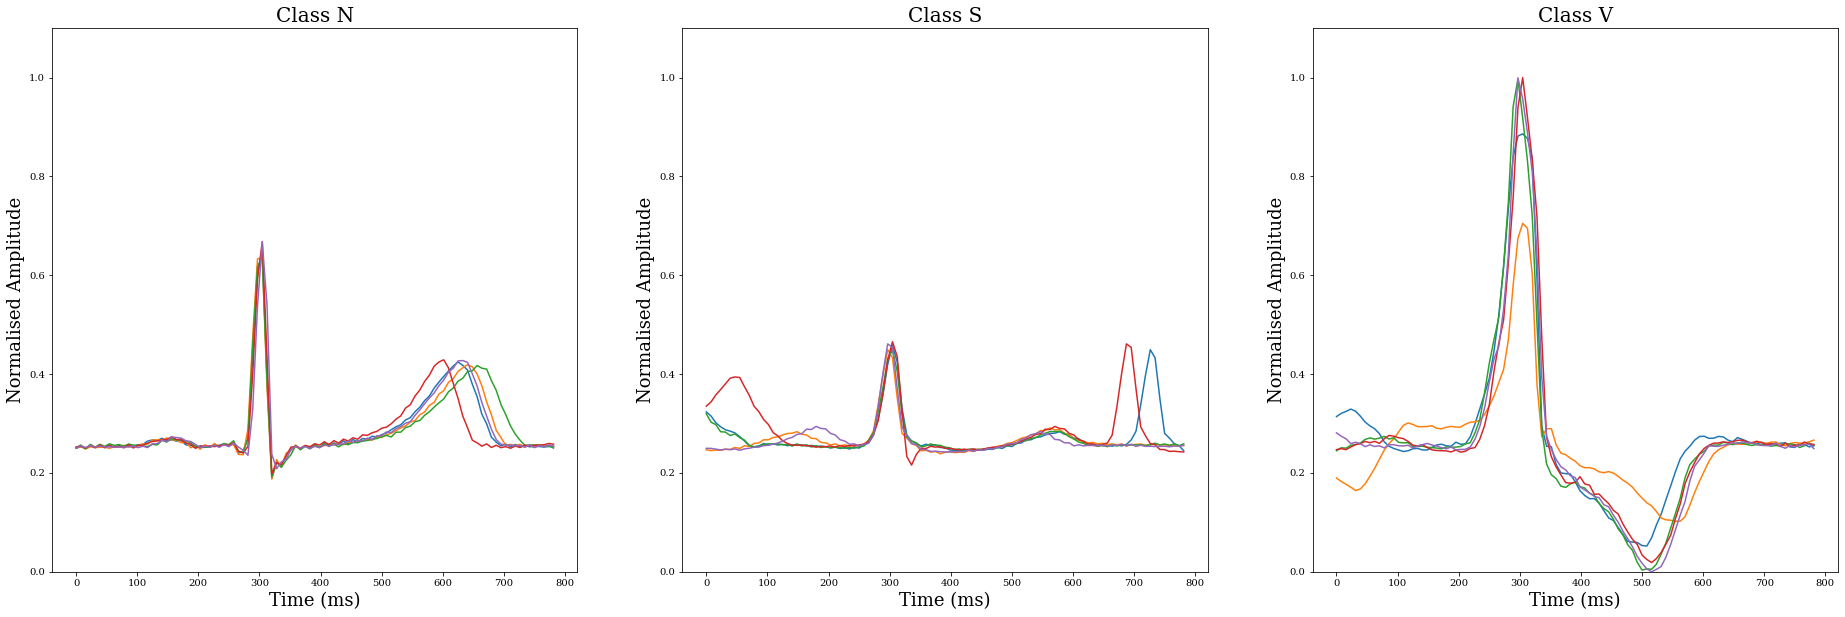

In [ ]:
# class 0 beats
cl_0_idx = beat_signal_recordings[beat_signal_recordings['Label'] == 'N'].index.values
cl_N = beat_signal_recordings.iloc[cl_0_idx]

# class 1 beats
cl_1_idx = beat_signal_recordings[beat_signal_recordings['Label'] == 'S'].index.values
cl_S = beat_signal_recordings.iloc[cl_1_idx]

# class 2 beats
cl_2_idx = beat_signal_recordings[beat_signal_recordings['Label'] == 'V'].index.values
cl_V = beat_signal_recordings.iloc[cl_2_idx]

# make plots for the different hbeat classes
plt.figure(figsize=(32,10))
plt.tight_layout()

range_x = cl_N.iloc[0][1:102].tolist() + cl_N.iloc[1][1:102].tolist() + cl_N.iloc[2][1:102].tolist() + cl_N.iloc[3][1:102].tolist() + cl_N.iloc[4][1:102].tolist() + cl_S.iloc[0][1:102].tolist() + cl_S.iloc[1][1:102].tolist() + cl_S.iloc[2][1:102].tolist() + cl_S.iloc[3][1:102].tolist() + cl_S.iloc[4][1:102].tolist() + cl_V.iloc[0][1:102].tolist() + cl_V.iloc[1][1:102].tolist() + cl_V.iloc[2][1:102].tolist() + cl_V.iloc[3][1:102].tolist() + cl_V.iloc[4][1:102].tolist()

plt.subplot(131)
for n in range(5):

    x_range = cl_N.iloc[n][1:102].tolist()

    ms_list = []
    for sample, _ in enumerate(x_range):
      ms_time = sample/128*1000
      ms_list.append(ms_time)

    normalised_x = (x_range - min(range_x)) / (max(range_x) - min(range_x))

    plt.plot(ms_list, normalised_x)
    plt.ylim(min(normalised_x), max(normalised_x)+0.1)
    plt.title('Class N', fontsize=20)
    plt.xlabel("Time (ms)", fontsize=18)
    plt.ylabel("Normalised Amplitude", fontsize=18)
    plt.ylim(0, 1.1)
plt.subplot(132)
for n in range(5):
    x_range = cl_S.iloc[n][1:102].tolist()

    ms_list = []
    for sample, _ in enumerate(x_range):
      ms_time = sample/128*1000
      ms_list.append(ms_time)

    normalised_x = (x_range - min(range_x)) / (max(range_x) - min(range_x))

    plt.plot(ms_list, normalised_x)
    plt.ylim(min(normalised_x), max(normalised_x)+0.1)
    plt.title('Class S', fontsize=20)
    plt.xlabel("Time (ms)", fontsize=18)
    plt.ylabel("Normalised Amplitude", fontsize=18)
    plt.ylim(0, 1.1)
plt.subplot(133)
for n in range(5):

    x_range = cl_V.iloc[n][1:102].tolist()
    
    ms_list = []
    for sample, _ in enumerate(x_range):
      ms_time = sample/128*1000
      ms_list.append(ms_time)

    normalised_x = (x_range - min(range_x)) / (max(range_x) - min(range_x))

    plt.plot(ms_list, normalised_x)
    plt.ylim(min(normalised_x), max(normalised_x)+0.1)
    plt.title('Class V', fontsize=20)
    plt.xlabel("Time (ms)", fontsize=18)
    plt.ylabel("Normalised Amplitude", fontsize=18)
    plt.ylim(0, 1.1)

### Checking for any missing numbers

In [ ]:
count_nan = beats_df.shape[0] - beats_df.dropna().shape[0]

print(count_nan)

0


### Remapping Labels to Numericals

In [ ]:
beats_df["Label"] = beats_df["Label"].map({'N': 0, 'S': 1, 'V': 2, 'F': 3}).astype('int')
beats_df.head(20)

,Label,0,1,2,3,4,Mean RR Interval (ms),Kubios Mean HR (BPM),Mean HR (BPM),HR Standard Deviation (BPM),...,VLF Power,LF Power,HF Power,Total Power,LF/HF Fract,Peak VLF,Peak LF,Peak HF,LF Fract,HF Fract
0,0,0.007825,0.078297,2.247497,0.957827,0.011017,743.846400,13.215632,29.624880,22.278790,...,53539.753538,70546.630791,104133.434484,228219.818813,0.677464,0.01505,0.041806,0.152174,40.386194,59.613806
1,0,0.014553,0.080943,2.168621,0.927365,0.007981,759.436800,12.944329,29.456275,22.295650,...,56467.731400,75494.030946,111630.868994,243592.631339,0.676283,0.01505,0.041806,0.152174,40.344193,59.655807
2,0,0.013304,0.072833,2.171591,0.917759,0.350514,760.942933,12.918709,29.437423,22.310864,...,56868.181371,76111.029107,111227.026119,244206.236597,0.684285,0.01505,0.041806,0.152174,40.627639,59.372361
3,0,0.002039,0.094957,2.346709,0.983551,0.020961,762.525867,12.891891,29.313775,22.288856,...,56194.452571,74880.706031,111867.479686,242942.638288,0.669370,0.01505,0.041806,0.152174,40.097153,59.902847
4,0,-0.007404,0.092753,2.342229,0.974707,0.011746,772.509867,12.725274,29.226272,22.340594,...,59507.488603,74956.953245,117756.493803,252220.935651,0.636542,0.01505,0.041806,0.152174,38.895549,61.104451
5,0,-0.004354,0.090982,2.229854,0.876772,0.008125,775.628800,12.674104,29.074069,22.323641,...,59312.268952,74460.359148,116512.633540,250285.261640,0.639075,0.01505,0.041806,0.152174,38.989994,61.010006
6,0,0.004317,0.120230,2.331125,0.909715,0.249947,783.714133,12.543349,28.891285,22.305410,...,61684.540749,73988.688282,117203.948028,252877.177059,0.631282,0.01505,0.041806,0.152174,38.698503,61.301497
7,0,-0.010538,0.116369,2.301868,0.908766,0.017400,792.763733,12.400164,28.687588,22.257929,...,64803.421463,75037.459372,120018.812407,259859.693242,0.625214,0.01505,0.041806,0.359532,38.469647,61.530353
8,0,0.074039,0.127896,2.100488,0.903852,0.008326,791.603200,12.418343,28.835615,22.344446,...,63144.138062,74308.343744,120894.324696,258346.806503,0.614655,0.01505,0.041806,0.152174,38.067279,61.932721
9,0,0.013592,0.060094,2.224043,0.899676,0.010939,792.836267,12.399029,28.808981,22.360785,...,62956.185987,74150.827957,121593.749166,258700.763110,0.609824,0.01505,0.041806,0.152174,37.881421,62.118579


In [ ]:
corr_matrix = beats_df.corr()

### Checking Feature Correlations for the Dataset

In [ ]:
print('_'*50)
print('Top 10 correlated features')
print('_'*50)
print(corr_matrix['Label'].sort_values(ascending=False).head(10))
print('_'*50)
print('Top 10 negatively correlated features')
print('_'*50)
print(corr_matrix['Label'].sort_values().head(10))

__________________________________________________
Top 10 high positively correlated features
__________________________________________________
Label                    1.000000
2                        0.321602
LF/HF Fract              0.298487
LF Fract                 0.245733
1                        0.232278
Mean RR Interval (ms)    0.208178
0                        0.175901
Peak VLF                 0.096281
RMSSD (ms)               0.078131
VLF Power                0.010052
Name: Label, dtype: float64
__________________________________________________
Top 10 high negatively correlated features
__________________________________________________
Mean HR (BPM)                 -0.252201
HF Fract                      -0.245733
Peak HF                       -0.185665
Kubios Mean HR (BPM)          -0.161924
HR Standard Deviation (BPM)   -0.151709
nn50                          -0.151639
pnn50                         -0.151639
Max HR (BPM)                  -0.137328
3                     

In [ ]:
# Rank all features by absolute correlation value 
display(corr_matrix['Label'].abs().sort_values(ascending=False))

Label                          1.000000
2                              0.321602
LF/HF Fract                    0.298487
Mean HR (BPM)                  0.252201
LF Fract                       0.245733
HF Fract                       0.245733
1                              0.232278
Mean RR Interval (ms)          0.208178
Peak HF                        0.185665
0                              0.175901
Kubios Mean HR (BPM)           0.161924
HR Standard Deviation (BPM)    0.151709
nn50                           0.151639
pnn50                          0.151639
Max HR (BPM)                   0.137328
3                              0.114005
Peak VLF                       0.096281
4                              0.091247
RMSSD (ms)                     0.078131
Min HR (BPM)                   0.056440
Peak LF                        0.055962
HF Power                       0.016062
VLF Power                      0.010052
Total Power                    0.006074
SDNN                           0.002733


## Train/Validation Split

### Get the class distribution for the dataset

Below we see that the dataset is heavily populated by normal 'N' beats (class 0), so we must take this into account when training our models. A model can achieve a high accuracy if it ONLY chooses to predict new data points as class 0.

____________________
Labels	 %
____________________
0    0.885961
2    0.074142
1    0.039897
Name: Label, dtype: float64
____________________


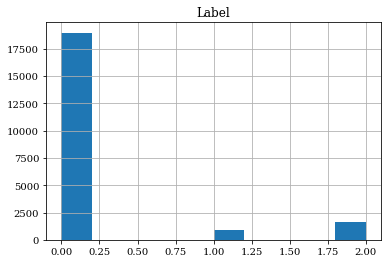

In [ ]:
print('_'*20)
print('Labels\t %')
print('_'*20)
print(beats_df['Label'].value_counts()/len(beats_df))
beats_df.hist('Label')

### Stratified Train/Validation Split

below we use a stratified training/validation split to use 80% of the data for training, and 20% for validating. 

The training dataset will retain the distribution of the original dataset so that the training data closely represents the original dataset. 

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for train_index, test_index in split.split(beats_df, beats_df['Label']):
    strat_train_set = beats_df.iloc[train_index]
    strat_test_set = beats_df.iloc[test_index] 

In [ ]:
print(f"Training Dataset Size: {strat_train_set.size}")

Training Dataset Size: 445224


In [ ]:
print(f"Testing Dataset Size: {strat_test_set.size}")

Testing Dataset Size: 111306


In [ ]:
print("Label\t%")
strat_train_set['Label'].value_counts()/len(strat_train_set)

Label	%


0    0.885950
2    0.074165
1    0.039886
Name: Label, dtype: float64

### Function for comparing model scores

In [ ]:
def compare_conf_matrix_scores(models, X, y):
    """
    This function compares predictive scores and confusion matrices fro different ML algorithms
    """
    
    for i, model in enumerate(models):

        # perform Kfold cross-validation returning prediction scores of each test fold.
        labels_train_pred = cross_val_predict(model, X, y, cv=5)
        print('_'*50)
        print('Model {} Confusion matrix'.format(i+1))
        print('-'*50)
        print(confusion_matrix(y, labels_train_pred))
        print('-'*50)

        acc_score = accuracy_score(y, labels_train_pred)
        prec_score = precision_score(y, labels_train_pred, average='macro')
        rec_score = recall_score(y, labels_train_pred, average='macro')
        f1_sc = f1_score(y, labels_train_pred, average='macro')
        print('Accuracy score: {}\nPrecision score: {}\nRecall Score: {}\nf1 score: {}'.format(acc_score,prec_score,rec_score, f1_sc))

        

    print('_'*50 + '\n')
    
#produce labels and features sets for the training stage
strat_features_train = strat_train_set.drop('Label', 1)
strat_labels_train = strat_train_set['Label']

### Standardising the training dataset.

In [ ]:
#initialize standardscaler instance
scaler = StandardScaler()

#standarized data, i.e,  substract mean and devides by variance
std_features = scaler.fit_transform(strat_features_train)

## MODEL TRAINING

### SVM Training & Tuning with K-Fold Cross Fold Validation

In [ ]:
#parameter grid
svc_param_grid = {'kernel':['linear', 'rbf', 'poly'], 'C':[1, 2, 3, 4, 4.8, 5, 5.2, 6, 10, 20], 'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 0.6, 0.7], 'degree':[0, 1, 2, 3, 4, 5, 6]}

# initialize classifier
svc = SVC(kernel='rbf',decision_function_shape='ovo',random_state=42, max_iter = 500)

# initialize grid search
svc_grid_search = GridSearchCV(svc, svc_param_grid, cv=5, scoring="f1_macro")

# fit classifiers using gridsearch
svc_grid_search.fit(std_features, strat_labels_train)

print("_"*50)
print('Model\t\tBest params\t\tBest score (F1)')
print("-"*50)
print("SVC\t\t", svc_grid_search.best_params_, svc_grid_search.best_score_)
print("_"*50)

__________________________________________________
Model		Best params		Best score
--------------------------------------------------
SVC		 {'C': 6, 'degree': 0, 'gamma': 0.1, 'kernel': 'rbf'} 0.9100510899664996
__________________________________________________


### KNN Training & Tuning with K-Fold Cross Fold Validation

In [ ]:
# KNN
parameters = {'n_neighbors': [3, 5, 7, 9], 'weights':['uniform', 'distance'], 'metric': ['minkowski', 'chebyshev']}

# initialize classifier
knn = KNeighborsClassifier()

# initialize grid search
knn_grid_search = GridSearchCV(knn, parameters, cv=5, scoring="f1_macro")

# fit classifiers using gridsearch
knn_grid_search.fit(std_features, strat_labels_train)

print("_"*50)
print('Model\t\tBest params\t\tBest score (F1)')
print("-"*50)
print("KNN\t\t", knn_grid_search.best_params_, knn_grid_search.best_score_)
print("_"*50)

__________________________________________________
Model		Best params		Best score
--------------------------------------------------
KNN		 {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'} 0.8832983140556496
__________________________________________________


### RFC Training & Tuning with K-Fold Cross Fold Validation

In [ ]:
# RFC 
parameters = {'n_estimators': [50, 75, 100, 125, 150, 175, 200], 'max_depth':[5, 8, 15, 25, 30], 'min_samples_split':[2, 5, 10, 15, 100] }

# initialize classifier
rfc = RandomForestClassifier()

# initialize grid search
rfc_grid_search = GridSearchCV(rfc, parameters, cv=5, scoring="f1_macro")

# fit classifiers using gridsearch
rfc_grid_search.fit(std_features, strat_labels_train)

print("_"*50)
print('Model\t\tBest params\t\tBest score (F1)')
print("-"*50)
print("RFC\t\t", rfc_grid_search.best_params_, rfc_grid_search.best_score_)
print("_"*50)

__________________________________________________
Model		Best params		Best score
--------------------------------------------------
RFC		 {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 125} 0.9042678052982212
__________________________________________________


### Set models with tuned hyperparameters

In [ ]:
best_svc = svc_grid_search.best_estimator_
best_knn = knn_grid_search.best_estimator_
best_rfc = rfc_grid_search.best_estimator_

__________________________________________________
Model 1 Confusion matrix
--------------------------------------------------
[[15097    71     3]
 [  210   465     8]
 [   22     9  1239]]
--------------------------------------------------
Accuracy score: 0.9811375846764775
Precision score: 0.9430920990634969
Recall Score: 0.8838442453635355
f1 score: 0.9102098455587001
__________________________________________________
Model 2 Confusion matrix
--------------------------------------------------
[[15069    93     9]
 [  254   414    15]
 [   29    12  1229]]
--------------------------------------------------
Accuracy score: 0.9759402008876431
Precision score: 0.9200332502314438
Recall Score: 0.8557141742693454
f1 score: 0.8834918312842989
__________________________________________________
Model 3 Confusion matrix
--------------------------------------------------
[[15126    45     0]
 [  246   428     9]
 [   25    11  1234]]
--------------------------------------------------
Accuracy

### Obtain Model Scoring with Validation Dataset

In [ ]:
strat_features_test = strat_test_set.drop('Label', 1)
strat_labels_test = strat_test_set['Label']

std_features_test = scaler.transform(strat_features_test)

svc_pred = best_svc.predict(std_features_test)
knn_pred = best_knn.predict(std_features_test)
rfc_pred = best_rfc.predict(std_features_test)

In [ ]:
svc_f1 = f1_score(strat_labels_test, svc_pred, average='macro')
svc_acc = accuracy_score(strat_labels_test, svc_pred)

knn_f1 = f1_score(strat_labels_test, knn_pred, average='macro')
knn_acc = accuracy_score(strat_labels_test, knn_pred)

rfc_f1 = f1_score(strat_labels_test, rfc_pred, average='macro')
rfc_acc = accuracy_score(strat_labels_test, rfc_pred)

## Final Model Scores

In [ ]:
print('_'*50)
print('                     (accuracy: {})'.format(svc_acc))
print('SVC Confusion matrix (f1 score: {})'.format(svc_f1))
print('-'*50)
print(confusion_matrix(strat_labels_test, svc_pred))
print('_'*50)
print('                     (accuracy: {})'.format(knn_acc))
print('KNN Confusion matrix (f1 score: {})'.format(knn_f1))
print('-'*50)
print(confusion_matrix(strat_labels_test, knn_pred))
print('_'*50)
print('                     (accuracy: {})'.format(rfc_acc))
print('RFC Confusion matrix (f1 score: {})'.format(rfc_f1))
print('-'*50)
print(confusion_matrix(strat_labels_test, rfc_pred))

__________________________________________________
                     (accuracy: 0.977808923148797)
SVC Confusion matrix (f1 score: 0.902948822545281)
--------------------------------------------------
[[3767   25    1]
 [  48  121    2]
 [  16    3  298]]
__________________________________________________
                     (accuracy: 0.9752394300397104)
KNN Confusion matrix (f1 score: 0.8849299754053047)
--------------------------------------------------
[[3766   24    3]
 [  54  110    7]
 [  14    4  299]]
__________________________________________________
                     (accuracy: 0.978743284279374)
RFC Confusion matrix (f1 score: 0.9025207357459708)
--------------------------------------------------
[[3778   14    1]
 [  54  113    4]
 [  17    1  299]]
